In [26]:
#im using CPU hehe
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

No GPU available, using the CPU instead


In [27]:
#do pip install transformers if haven't

In [28]:
import pandas as pd

df = pd.read_csv("./GenshinReview.csv")
df.shape

(2000, 2)

In [29]:
df.sample(10)

,score,content
1860,5,i really enjoy this game so far graphics are a...
353,4,it is a great game but everytime the hoyoverse...
1333,5,beautiful graphics a perfect eye candy immersi...
905,1,unplayable on phone it kicks me out every few ...
1289,5,congrats for winning in the best mobile games ...
1273,3,amazing game gripping story and well written c...
938,5,ngl i found this game off of a cute fan made p...
1731,2,graphics and pretty neat but i had to rate it ...
65,1,greedy company that does not reinvest into the...
1323,4,the music the world the graphics everything is...


In [30]:
#creating label called sentiment from the score reviews
#1-2: negative
#3: neutral
#4-5: positive

def map_rating_to_sentiment(rating):
    if rating in [1, 2]:
        return 0
    elif rating == 3:
        return 1
    elif rating in [4, 5]:
        return 2

df['sentiment'] = df['score'].apply(map_rating_to_sentiment)

df.head(20)

,score,content,sentiment
0,5,the game is great audio background etc are all...,2
1,4,the world building characters art design and g...,2
2,4,this game is fun but at the time that fontaine...,2
3,4,this game is beautiful and the game is very fu...,2
4,4,lost on furina banner but all together it is a...,2
5,1,after years of waiting still no controller sup...,0
6,4,i love genshin but there is only one problem a...,2
7,4,awesome graphics if your phone can handle and ...,2
8,1,i do not know what is happening but when i cli...,0
9,5,the story is at peak level and not to mention ...,2


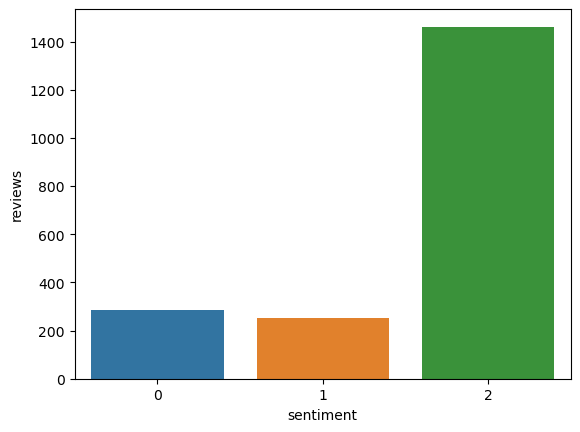

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

#for now we have 2000 rows of reviews. we'll add more data perhaps later if the accuracy is still bad.
x = df.sentiment.value_counts()
sns.barplot(x=x.index, y=x)
plt.gca().set_ylabel('reviews')
plt.show()

In [32]:
sentences = df.content.values
labels = df.sentiment.values

In [33]:
from transformers import BertTokenizer
#using pr etrained bert tokenizer
print("Loading BERT Tokenizer")
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)

Loading BERT Tokenizer


In [34]:
print("Original: ", sentences[0])
#yes it's not perfect, game word terms like primogems are not identified as english word.
print("Tokenized: ", tokenizer.tokenize(sentences[0]))
#tokenization time
print("Token IDS: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original:  the game is great audio background etc are all great but one thing i do not like is the wish system i do not have a five star character all i have got are four star character so it is suck to be a free to play unless you save a lot or primogems one good thing about it is you do not need a five star character to beat and enjoy the game though i do need the mc though as she can upgrade her constellations with just lvling up rank or the story progress yeah it is hard to earn primogems i guess i better sucked it up
Tokenized:  ['the', 'game', 'is', 'great', 'audio', 'background', 'etc', 'are', 'all', 'great', 'but', 'one', 'thing', 'i', 'do', 'not', 'like', 'is', 'the', 'wish', 'system', 'i', 'do', 'not', 'have', 'a', 'five', 'star', 'character', 'all', 'i', 'have', 'got', 'are', 'four', 'star', 'character', 'so', 'it', 'is', 'suck', 'to', 'be', 'a', 'free', 'to', 'play', 'unless', 'you', 'save', 'a', 'lot', 'or', 'primo', '##gem', '##s', 'one', 'good', 'thing', 'about', 'it', '

In [35]:
input_ids = []

for sent in sentences:
  encoded_sent = tokenizer.encode(
      sent,
      add_special_tokens = True
  )
  input_ids.append(encoded_sent)

print("Original: ", sentences[0])
print("Token IDs: ", input_ids[0])


Original:  the game is great audio background etc are all great but one thing i do not like is the wish system i do not have a five star character all i have got are four star character so it is suck to be a free to play unless you save a lot or primogems one good thing about it is you do not need a five star character to beat and enjoy the game though i do need the mc though as she can upgrade her constellations with just lvling up rank or the story progress yeah it is hard to earn primogems i guess i better sucked it up
Token IDs:  [101, 10103, 11336, 10127, 11838, 18160, 23158, 12575, 10320, 10367, 11838, 10502, 10399, 21973, 151, 10154, 10497, 11531, 10127, 10103, 33020, 10472, 151, 10154, 10497, 10574, 143, 12049, 11424, 14989, 10367, 151, 10574, 15517, 10320, 11443, 11424, 14989, 10297, 10197, 10127, 59299, 10114, 10346, 143, 12487, 10114, 11923, 53804, 10855, 21343, 143, 15632, 10362, 12195, 21538, 10107, 10399, 12050, 21973, 10935, 10197, 10127, 10855, 10154, 10497, 15415, 143,

In [36]:
print("Max sentence length: ", max([len(sen) for sen in input_ids]))

Max sentence length:  267


In [37]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 64

print("Padding/truncating all sentences to %d values" % MAX_LEN)
print('Padding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')

print("Done")

Padding/truncating all sentences to 64 values
Padding token: "[PAD]", ID: 0
Done


In [38]:
input_ids[0]

array([  101, 10103, 11336, 10127, 11838, 18160, 23158, 12575, 10320,
       10367, 11838, 10502, 10399, 21973,   151, 10154, 10497, 11531,
       10127, 10103, 33020, 10472,   151, 10154, 10497, 10574,   143,
       12049, 11424, 14989, 10367,   151, 10574, 15517, 10320, 11443,
       11424, 14989, 10297, 10197, 10127, 59299, 10114, 10346,   143,
       12487, 10114, 11923, 53804, 10855, 21343,   143, 15632, 10362,
       12195, 21538, 10107, 10399, 12050, 21973, 10935, 10197, 10127,
       10855])

In [39]:
attention_mask = []

for sent in input_ids:
  att_mask = [int(token_id > 0) for token_id in sent]

  attention_mask.append(att_mask)

In [40]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_labels, test_labels = train_test_split(input_ids,labels, random_state=42, test_size=0.1)
train_mask, test_mask, _, _ = train_test_split(attention_mask, labels, random_state=42, test_size=0.1)

train_input, validation_input, train_labels, validation_labels = train_test_split(train_input, train_labels, random_state= 43, test_size=0.15)
train_mask, validation_mask, _, _ = train_test_split(train_mask, train_mask, random_state=43, test_size=0.15)

In [41]:
import numpy as np
print("== Train ==")
print("Input: ", train_input.shape)
print("Label: ", train_labels.shape)
print("Mask: ", np.array(train_mask).shape)

print("\n== Validation ==")
print("Input: ", validation_input.shape)
print("Label: ", validation_labels.shape)
print("Mask: ", np.array(validation_mask).shape)

print("\n== Test ==")
print("Input: ", test_input.shape)
print("Label: ", test_labels.shape)
print("Mask: ", np.array(test_mask).shape)

== Train ==
Input:  (1530, 64)
Label:  (1530,)
Mask:  (1530, 64)

== Validation ==
Input:  (270, 64)
Label:  (270,)
Mask:  (270, 64)

== Test ==
Input:  (200, 64)
Label:  (200,)
Mask:  (200, 64)


In [42]:
train_input = torch.tensor(train_input)
train_labels = torch.tensor(train_labels)
train_mask = torch.tensor(train_mask)

validation_input = torch.tensor(validation_input)
validation_labels = torch.tensor(validation_labels)
validation_mask = torch.tensor(validation_mask)

test_input = torch.tensor(test_input)
test_labels = torch.tensor(test_labels)
test_mask = torch.tensor(test_mask)

In [43]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_input, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_input, validation_mask, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_input, test_mask, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [44]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-uncased",
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
params = list(model.named_parameters())

print("The BERT model has {:} different named parameters.".format(len(params)))

print("==== Embedding Layer ====")
for p in params[0:5]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== First Transformers ====")
for p in params[5:21]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== Output Layer ====")
for p in params[-4:]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.
==== Embedding Layer ====
bert.embeddings.word_embeddings.weight                       (105879, 768)
bert.embeddings.position_embeddings.weight                     (512, 768)
bert.embeddings.token_type_embeddings.weight                     (2, 768)
bert.embeddings.LayerNorm.weight                                   (768,)
bert.embeddings.LayerNorm.bias                                     (768,)
==== First Transformers ====
bert.encoder.layer.0.attention.self.query.weight               (768, 768)
bert.encoder.layer.0.attention.self.query.bias                     (768,)
bert.encoder.layer.0.attention.self.key.weight                 (768, 768)
bert.encoder.layer.0.attention.self.key.bias                       (768,)
bert.encoder.layer.0.attention.self.value.weight               (768, 768)
bert.encoder.layer.0.attention.self.value.bias                     (768,)
bert.encoder.layer.0.attention.output.dense.weight             (768, 768)
bert.

In [46]:
optimizer = AdamW(
    model.parameters(),
    lr = 2e-5,
    eps = 1e-8
)

c:\Users\ASUS\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [47]:
from transformers import get_linear_schedule_with_warmup

epochs = 5

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [48]:
import numpy as np

def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [49]:
import time
import datetime

def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [50]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

loss_values = []

for epoch_i in range(0, epochs):

#Training time
  print("======= Epoch {:} / {:} =======".format(epoch_i+1, epochs))
  print("Training...")

  t0 = time.time()

  total_loss = 0
#only to prepare the model in a state of where it's ready for training
  model.train()

  #for each batch of training data
  for step, batch in enumerate(train_dataloader):
    
    #progress update every 40 batches
    if step % 40 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)

      print("Batch {:>5,} of {:>5,}.     Elapsed: {:}".format(step, len(train_dataloader), elapsed))
    
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad()

    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)
    
    loss = outputs[0]
    total_loss += loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()

  avg_train_loss = total_loss / len(train_dataloader)
  loss_values.append(avg_train_loss)

  print("   Average training loss: {0:.2f}".format(avg_train_loss))
  print("   Training epoch took: {:}".format(format_time(time.time() - t0)))

#validation time
  print("Running Validation...")
  t0 = time.time()
  model.eval()
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
      outputs = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  
  print("   Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
  print("   Validation took: {:}".format(format_time(time.time() - t0)))

print("Training complete!")

======= Epoch 1 / 5 =======
Training...
Batch    40 of    48.     Elapsed: 0:06:48
   Average training loss: 0.81
   Training epoch took: 0:08:06
Running Validation...
   Accuracy: 0.77
   Validation took: 0:00:26
======= Epoch 2 / 5 =======
Training...
Batch    40 of    48.     Elapsed: 0:06:48
   Average training loss: 0.68
   Training epoch took: 0:08:09
Running Validation...
   Accuracy: 0.77
   Validation took: 0:00:26
======= Epoch 3 / 5 =======
Training...
Batch    40 of    48.     Elapsed: 0:06:49
   Average training loss: 0.59
   Training epoch took: 0:08:08
Running Validation...
   Accuracy: 0.76
   Validation took: 0:00:27
======= Epoch 4 / 5 =======
Training...


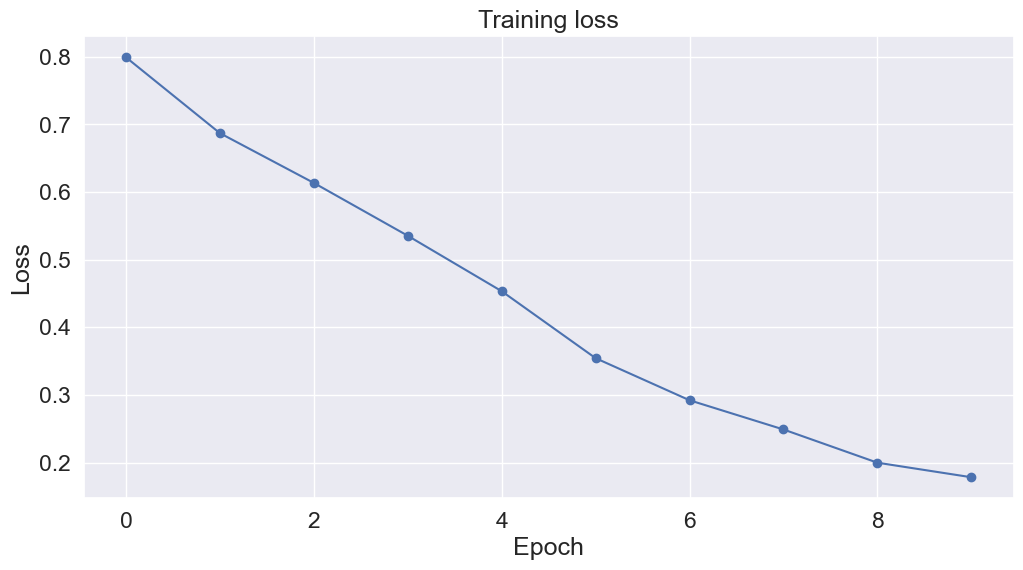

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt


#plotting will be continued once this thing is done training bro
import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
print("Predicting labels for {:,} test sentences".format(len(test_input)))

model.eval()

prediction, true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask)
    
  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  prediction.append(logits)
  true_labels.append(label_ids)

print("finally??? done!!!!")

Predicting labels for 200 test sentences
finally??? done!!!!


In [ ]:
from sklearn.metrics import matthews_corrcoef

flat_prediction = [item for sublist in prediction for item in sublist]
flat_prediction = np.argmax(flat_prediction, axis=1).flatten()

flat_true_labels = [item for sublist in true_labels for item in sublist]

mcc = matthews_corrcoef(flat_true_labels, flat_prediction)

print("MATTHEWS_CC: %.3f" %mcc)

MATTHEWS_CC: 0.318


In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(flat_true_labels, flat_prediction)

print("ACCURACY: %.3f" %acc)

ACCURACY: 0.725
